## Реализация Double DQN с буфером памяти в PyTorch

Реализуем метод обучения Double DQN с буфером памяти и двумя ИНС с одинаковой структурой:
            
    одна ИНС будет обучаться текущей Q-функции, 
    вторая ИНС используется для формирования целей обновления.

Значение Q-функции для состояния $s$ и действия $a$ будем обозначать $\widehat q(s,a,\theta_k)$, где $\theta_k$ - это текущие значения весов обучаемой ИНС.
Для генерации траектории будем использовать $\varepsilon$-жадную стратегию на основе текущих значений обучаемой Q-функции.  

Значения ИНС, которая формирует целевые значения, будем обозначать за $\widehat q(s,a,\theta^{-})$, где $\theta^{-}$ - это текущие значения весов второй ИНС. Цель обновления формируется в виде 

$$r + \gamma \max_a \widehat q(s',a,\theta^{-}),$$

где $(s,a,r,s')$ - это информация о текущем положении на траектории. Для приближения к этой цели обновляются веса у обучаемой ИНС. Вторая сеть копирует веса первой после нескольких итераций обучения первой сети.

Для большей устойчивости метода градиентного спуска, обучение необходимо проводить не по одному шагу по траектории, а пакетом. Для этого нужен буфер с памятью для опыта, генерируемого по поведенческой стратегии, который сохраняет строку данных вида $(s,a,r,s',terminated)$. В ходе шага обучения из этого буфера выбирается случайным образом набор строчек, формируются обучающие данные и на этих данных обучается первая ИНС.

Буфер имеет фиксированный размер. Когда буфер заполнен, то при помещении в него новых строчек старые строки удаляются (иными словами, буфер представляет собой очередь). Использование пакета данных из буфера памяти позволяет ещё и декоррелировать обучающие данные.

Итоговая функция ошибки, минимизацию которой нужно провести на каждом шаге обновления параметров обучаемой ИНС, имеет вид

$$
J(\theta_k) = \frac 1 N \sum_{i=1}^N [r_i + \gamma (1-terminated_i)  \max_a \widehat q(s'_i,a,\theta^{-}) - \widehat q(s_i,a_i,\theta_k)]^2,
$$
где $(s_i, a_i, r_i, s_i', terminated_i)$, $i=1,...,N$, это выборка из буфера памяти. В переменной $terminated_i$ хранится флаг об окончании эпизода, если он равен 1, то целью обновления является просто полученное вознаграждение $r_i$, так как терминальные состояния имеют по умолчанию ценность 0.
Шаг градиентного спуска имеет вид:

$$
\theta_{k+1} = \theta_k + \alpha \frac 1 N \sum_{i=1}^N [r_i + \gamma  (1-terminated_i) \max_a \widehat q(s'_i,a,\theta^{-}) - \widehat q(s_i,a_i,\theta_k)] \, grad_\theta \widehat q(s_i,a_i,\theta_k)
$$



Как отмечено в лекциях, 
    
    нелинейное приближение
    использование разделённой стратегии
    и формирование цели обновления с бутстреппингом     
    
применяемые одновременно не дают теоретических гарантий сходимости. На практике, сходимость есть при аккуратном подборе гиперпараметров, но график функции ошибки отличается от типичного графика функции ошибки при обучении с учителем, а именно график не убывает к нулю, а сначала значения функции ошибки растут и лишь затем происходит убывание ошибки к нулю, возможно со значительными колебаниями.

In [3]:
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# для избежания ошибки при отрисовки графиков
#https://programmerah.com/solved-omp-error-15-initializing-libiomp5md-dll-but-found-libiomp5md-dll-already-initialized-35360/

In [7]:
# Импорт нужных пакетов
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import time
from collections import deque

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Как и для метода Vanilla DQN, агент будет получать теперь уже два экземпляра класса, зазадющего ИНС, при создании агента. 

Реализуем класс для хранения полученного опыта ReplayBuffer на основе такой структуры данных, как очередь. В этом классе реализуем методы

    add(state, action, reward, next_state, done) - сохранить строку данных (s,a,r,s',done) в буфере памяти
    
    sample(batch_size) - вернуть batch_size строчек из массива с опытом, строки выбираются случайно. В строке
    states, actions, rewards, next_states, dones.
    
    len(exp_replay) - возвращает число элементов в буфере.
    
Метод `sample()` будет ещё дополнительно приводить данные к  типу данных Tensor, чтобы данные можно было напрямую использовать для обучения ИНС. Также в методе  `sample()` будем перемещать данные на `device`, где будет проходить обучение ИНС.

In [9]:
def data_to_tensors(state, action, reward, next_state, terminated): 
    # перевод данных в тензоры
    state = torch.tensor(state).float()
    action = torch.tensor(action).long()
    reward = torch.tensor(reward).float()
    next_state = torch.tensor(next_state).float()
    terminated = torch.tensor(terminated).float()
    # флаги переводим в float, а не в целые, так как done используется в вычислениях
    
    return state, action, reward, next_state, terminated

class ReplayBuffer:
    def __init__(self, size):
        self.size = size  # максимальное число элементов
        self.buffer = deque(maxlen=size)  
        
    def __len__(self):
        return len(self.buffer)

    def add(self, state, action, reward, next_state, terminated):
        item = data_to_tensors(state, action, reward, next_state, terminated)
        self.buffer.append(item)

    def sample(self, batch_size):
        samples = random.sample(self.buffer, k=batch_size)
        # из samples выбрать отдельно состояния, действия, вознаграждения, новые состояния
        # zip выдаёт тип zip, затем приведение к списку
        states, actions, rewards, next_states, terminates = tuple(zip(*samples))
        # получим список состояний, действий и т.д.    
        states = torch.stack(states).to(device)
        actions = torch.stack(actions).to(device)
        rewards = torch.stack(rewards).to(device)
        next_states = torch.stack(next_states).to(device)
        terminates = torch.stack(terminates).to(device)
    
        return states, actions, rewards, next_states, terminates   

Далее, напишем класс DQN-агента. Для этого зададим набор гиперпараметров.

In [11]:
BUFFER_SIZE = int(1e5)  # размер буфера памяти
BATCH_SIZE = 64         # размер пакета
UPDATE_EVERY = 4        # как часто проводить обучение сети
UPDATE_EVERY_Q = 50     # как часто обновлять параметры целевой сети

In [13]:
class DQNAgent():

    def __init__(self, env, model, model_target, alpha=0.001, gamma=0.99, epsilon=0.1, hard_update = True, tau = 1e-3):
        # инициализация полей
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = torch.tensor(gamma).float().to(device)
        self.nA = env.action_space.n
        # Новые поля
        self.hard_update = hard_update
        self.tau = tau #коэффициент для мягкого обновления параметров целевой сети        

        # инициализация сетей
        self.Q_train = model
        self.Q_target = model_target
        self.optimizer = torch.optim.Adam(self.Q_train.parameters(), lr=self.alpha)

        # буфер памяти
        self.memory = ReplayBuffer(BUFFER_SIZE)
        # счётчик, для определения момента обновления параметров сети
        self.t_step = 0

    def best_action(self, state):
        # состояние в тензор
        state = torch.tensor(state).float().to(device)
        # вычисляем отклик ИНС, используем torch.no_grad(), чтобы не вычислялись градиенты  
        with torch.no_grad():
            q_values = self.Q_train(state)
        # жадный выбор
        return torch.argmax(q_values).cpu().item() 
        
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.nA)
        return self.best_action(state)
    
    def update(self, state, action, reward, next_state, done):
        # Сохранить строку данных (s,a,r,s',done) в буфер
        self.memory.add(state, action, reward, next_state, done)        
        
        self.t_step = self.t_step + 1
        # обучаться каждые UPDATE_EVERY шагов.
        if self.t_step  % UPDATE_EVERY == 0:
            #  если в памяти достаточно много сэмплов, то обучаться
            if len(self.memory) > BATCH_SIZE:
                self.learn()

    def learn(self):
        # получаем данные из буфера
        states, actions, rewards, next_states, dones = self.memory.sample(BATCH_SIZE)

        # Находим max Q_2(s,a), вычисляем отклик второй ИНС без обучения, 
        with torch.no_grad():
            q_next_states = agent.Q_target(next_states)
        # вычисляем целевые значения для обучения первой ИНС (max в каждой строке, затем выбор значений)
        q_targets_next = q_next_states.max(1)[0]
        q_targets = rewards + self.gamma * q_targets_next * (1 - dones)
        
        # Обучение: находим отклики первой ИНС на пакет состояний
        # из каждой строки [Q(s,a1), Q(s,a2),...] выбираем Q(s,a) в соответствии с фактическими сделанными действиями
        q_expected = agent.Q_train(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # функция ошибки и шаг градиентного спуска
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # обновить целевую сеть
        self.update_Qtarget(agent.hard_update)

    
    # обновление параметров целевой ИНС
    def update_Qtarget(self, hard_update = True):
        if hard_update:
            if self.t_step % UPDATE_EVERY_Q == 0:
                agent.Q_target.load_state_dict(agent.Q_train.state_dict())
        else:
            for target_param, trained_param in zip(agent.Q_target.parameters(), agent.Q_train.parameters()):
                target_param.data.copy_(self.tau*trained_param.data + (1.0-self.tau)*target_param.data)

    def play(self, env, n_episodes):
        for episode in tqdm(range(n_episodes)):
            state, _ = env.reset()
            while True:
                # выбираем действия по стратегии
                action = agent.best_action(state)
                state, reward, terminated, truncated, _ = env.step(action)
                if terminated or truncated:
                    break
                
    def save_model(self, fname):
        torch.save(self.Q_target, 'savedModels/'+str(fname)+'.pkl')
        print("Net saved to: ", 'savedModels/'+str(fname)+'.pkl')
        
    def load_model(self, fname):
        self.Q_train = torch.load(fname, map_location=torch.device('cpu'), weights_only=False).to(device)
        self.Q_target = torch.load(fname, map_location=torch.device('cpu'), weights_only=False).to(device)
        self.Q_train.eval()
        self.Q_target.eval()
        print("Model loaded")

В методе `update_Qtarget()`, которая занимается обновлением параметров целевой ИНС, мы либо просто копируем веса из обучаемой ИНС в целевую, либо производим так называемое мягкое обновление (англ. soft update). Суть его в следующем: пусть $\theta_{target}$ параметры целевой ИНС, $\theta_{train}$ параметры обучаемой ИНС. Тогда мягкое обновление происходит по правилу
$$ \theta_{target} = \tau * \theta_{train} + (1-\tau) * \theta_{target}.$$
Число $\tau$ от 0 до 1, и он отвечает за скорость постепенного изменения параметров целевой ИНС.

Теперь напишем управляющий алгоритм для метода DQN.

In [15]:
def DQN_control(env, agent, num_episodes=10000, 
                      eps_start=1.0, eps_decay = 0.995, eps_min = 0.01,
                       goal_score=200):
    # Инициализация   
    agent.epsilon = eps_start
    start_time = time.time()  # счётчик времени выполнения
    running_gain = goal_score - 1
    
    for i in range(num_episodes):
        state, _ = env.reset()
        
        # запускаем эпизод взаимодействия со средой        
        while True:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            agent.update(state, action, reward, next_state, terminated)
            state = next_state
            if terminated or truncated:
                break
        
        # Снижение eps и alpha
        agent.epsilon = max(agent.epsilon * eps_decay, eps_min)
        
        if i % 50 ==0:
            running_gain = np.mean(np.array(env.return_queue)[-100:])
            print("\rДоход: {:.2f} в эпизоде {}".format(running_gain, i))
            print("--- {} сек ---".format(time.time() - start_time))
            start_time = time.time()

        # выход из цикла при достижении целевого среднего дохода
        if running_gain > goal_score:  
            print("Успех на эпизоде {}!".format(i))
            # поместить в целевую сеть итоговые веса
            agent.update_Qtarget(hard_update = True)
            break   

# Пример 1

Сначала рассмотрим работу метода DQN на примере задачи об обратном маятнике.

In [17]:
env = gym.make('CartPole-v1')
env = gym.wrappers.RecordEpisodeStatistics(env,2000)

print('Размерность вектора состояний: ', env.observation_space.shape[0])
print('Количество действий: ', env.action_space.n)

Размерность вектора состояний:  4
Количество действий:  2


Формируем структуру сети и создаём два экзампляра. Используем ИНС с 1 слоем шириной 64 нейрона.

In [19]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        #self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        return self.fc2(x)
    
model = QNetwork(env.observation_space.shape[0], env.action_space.n).to(device)
model_target = QNetwork(env.observation_space.shape[0], env.action_space.n).to(device)

# Гиперпараметры
BUFFER_SIZE = int(1e5)  # размер буфера памяти
BATCH_SIZE = 64         # размер пакета
UPDATE_EVERY = 4        # как часто проводить обучение сети
UPDATE_EVERY_Q = 50     # как часто обновлять параметры целевой сети

Задаём гиперпараметры, создаём агента.

In [21]:
env = gym.make('CartPole-v1')
env = gym.wrappers.RecordEpisodeStatistics(env,2000)

agent = DQNAgent(env, model, model_target)

In [22]:
state, _ = env.reset()
print(state)

agent.best_action(state)

[-0.02281267  0.04718286  0.01407039 -0.00902464]


1

Проводим обучение.

In [25]:
DQN_control(env, agent, goal_score = 250);

Доход: 11.00 в эпизоде 0
--- 0.001995086669921875 сек ---
Доход: 19.78 в эпизоде 50
--- 0.4757578372955322 сек ---
Доход: 18.16 в эпизоде 100
--- 0.40294742584228516 сек ---
Доход: 15.90 в эпизоде 150
--- 0.4009530544281006 сек ---
Доход: 23.96 в эпизоде 200
--- 0.8774123191833496 сек ---
Доход: 33.60 в эпизоде 250
--- 1.021324872970581 сек ---
Доход: 38.89 в эпизоде 300
--- 1.111598014831543 сек ---
Доход: 42.96 в эпизоде 350
--- 1.0707478523254395 сек ---
Доход: 45.97 в эпизоде 400
--- 1.2767558097839355 сек ---
Доход: 49.80 в эпизоде 450
--- 1.3024487495422363 сек ---
Доход: 58.21 в эпизоде 500
--- 1.677288293838501 сек ---
Доход: 83.47 в эпизоде 550
--- 2.6856491565704346 сек ---
Доход: 169.04 в эпизоде 600
--- 6.06900691986084 сек ---
Доход: 270.67 в эпизоде 650
--- 8.042558670043945 сек ---
Успех на эпизоде 650!


In [55]:
agent.save_model("CartPole_DDQN_64neurons")

Net saved to:  savedModels/CartPole_DDQN_64neurons.pkl


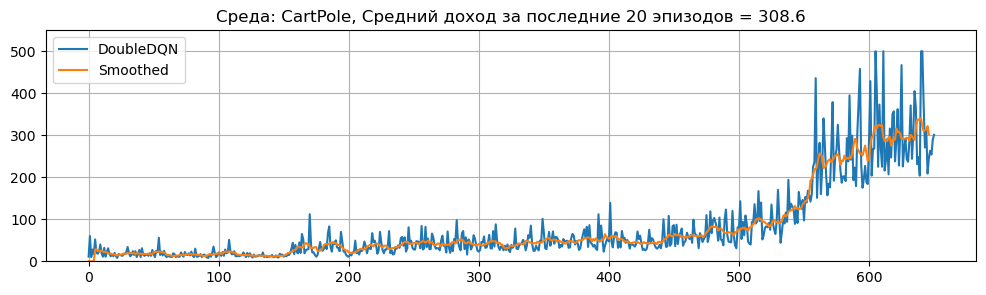

In [27]:
def plot_rewards(env_name, returns, label):
    # сглаженный вектор доходов
    returns_smoothed = np.pad(np.convolve(returns, np.ones(10)/10, mode='valid'),[5, 0])
    fig = plt.figure(figsize=(12, 3))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.plot(returns_smoothed, label="Smoothed")
    plt.grid()
    plt.legend()
    plt.ylim(0, 550)
    plt.show()

returns = np.array(env.return_queue)
plot_rewards("CartPole", returns, 'DoubleDQN')

Ниже можно запустить 100 эпизодов симуляции работы обученного агента.

In [39]:
# можно подгрузить обученные веса
agent = DQNAgent(env, model, model_target)
agent.load_model("savedModels/CartPole_DDQN_64neurons.pkl")

Model loaded


In [29]:
env = gym.make('CartPole-v1')
env = gym.wrappers.RecordEpisodeStatistics(env)

gains = agent.play(env,100)

print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.75it/s]

Средний доход:  450.01
Минимальный доход:  274.0


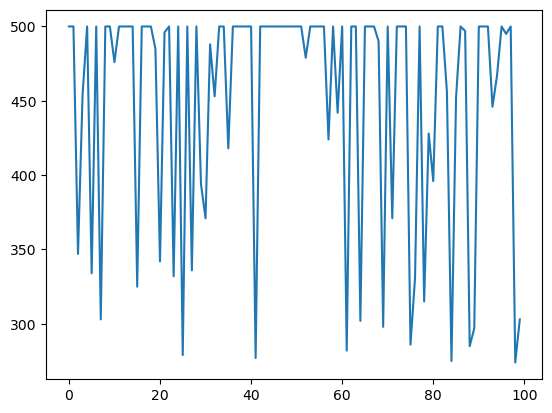

In [31]:
plt.plot(np.array(env.return_queue))

In [35]:
# демонстрация работы агента
env = gym.make('CartPole-v1', render_mode='human')
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env,1)
print("Число шагов:", env.return_queue[-1])

env.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.01s/it]

Число шагов: 432.0


# Пример 2

Рассмотрим задачу о посадке лунного модуля.

In [37]:
env = gym.make('LunarLander-v3')
env = gym.wrappers.RecordEpisodeStatistics(env,2000)

print('Размерность вектора состояний: ', env.observation_space.shape[0])
print('Количество действий: ', env.action_space.n)

Размерность вектора состояний:  8
Количество действий:  4


Поскольку в сравнении с задачей о маятнике, здесь вектор состояний больше и число действией больше, то используем сеть, где в скрытом слое 128 нейронов.


In [39]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        #self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        return self.fc2(x)
    
model = QNetwork(env.observation_space.shape[0], env.action_space.n).to(device)
model_target = QNetwork(env.observation_space.shape[0], env.action_space.n).to(device)

# Гиперпараметры
BUFFER_SIZE = int(1e5)  # размер буфера памяти
BATCH_SIZE = 64         # размер пакета
UPDATE_EVERY = 4        # как часто проводить обучение сети
UPDATE_EVERY_Q = 50     # как часто обновлять параметры целевой сети

In [41]:
env = gym.make('LunarLander-v3')
env = gym.wrappers.RecordEpisodeStatistics(env,2000)

agent = DQNAgent(env, model, model_target, alpha=0.004)

In [43]:
s, _ = env.reset()
print(s)

agent.get_action(s)

[-0.00447454  1.4091134  -0.45325136 -0.08030828  0.0051918   0.10266819
  0.          0.        ]


0

In [69]:
gains = DQN_control(env, agent, goal_score = 200);

Доход: -127.46 в эпизоде 0
--- 0.015957117080688477 сек ---
Доход: -165.21 в эпизоде 50
--- 2.2639479637145996 сек ---
Доход: -148.42 в эпизоде 100
--- 3.1844875812530518 сек ---
Доход: -115.89 в эпизоде 150
--- 4.779226064682007 сек ---
Доход: -88.22 в эпизоде 200
--- 9.98331356048584 сек ---
Доход: -59.59 в эпизоде 250
--- 19.45599341392517 сек ---
Доход: -24.67 в эпизоде 300
--- 24.11454153060913 сек ---
Доход: 16.07 в эпизоде 350
--- 21.39780330657959 сек ---
Доход: -9.74 в эпизоде 400
--- 13.068068265914917 сек ---
Доход: -25.29 в эпизоде 450
--- 17.098801374435425 сек ---
Доход: 61.90 в эпизоде 500
--- 19.05207347869873 сек ---
Доход: 132.61 в эпизоде 550
--- 13.940736055374146 сек ---
Доход: 148.44 в эпизоде 600
--- 14.323712587356567 сек ---
Доход: 162.41 в эпизоде 650
--- 12.790809869766235 сек ---
Доход: 179.46 в эпизоде 700
--- 11.819406270980835 сек ---
Доход: 185.82 в эпизоде 750
--- 11.101831436157227 сек ---
Доход: 183.12 в эпизоде 800
--- 11.952051639556885 сек ---
Дохо

In [75]:
agent.save_model("LunarLander_DDQN_128neurons")

Net saved to:  savedModels/LunarLander_DDQN_128neurons.pkl


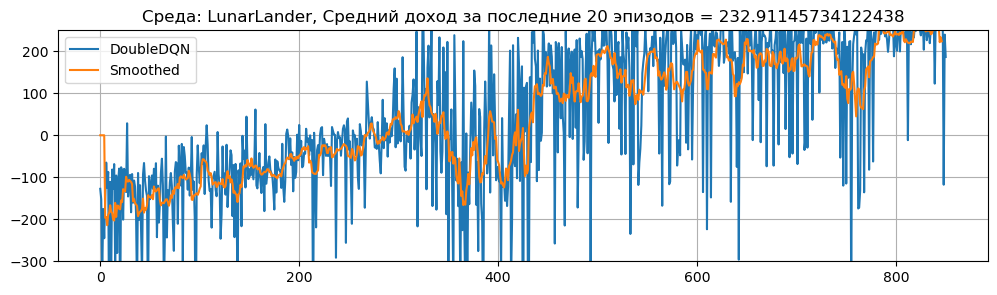

In [71]:
def plot_rewards(env_name, returns, label):
    # сглаженный вектор доходов
    returns_smoothed = np.pad(np.convolve(returns, np.ones(10)/10, mode='valid'),[5, 0])
    fig = plt.figure(figsize=(12, 3))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.plot(returns_smoothed, label="Smoothed")
    plt.grid()
    plt.legend()
    plt.ylim(-300, 250)
    plt.show()

returns = np.array(env.return_queue)
plot_rewards("LunarLander", returns, 'DoubleDQN')

In [45]:
# можно подгрузить обученные веса
agent = DQNAgent(env, model, model_target)
agent.load_model("savedModels/LunarLander_DDQN_128neurons.pkl")

Model loaded


Ниже можно запустить 100 эпизодов симуляции работы обученного агента.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.64it/s]

Средний доход:  226.5423502848424
Минимальный доход:  -245.97186240232458


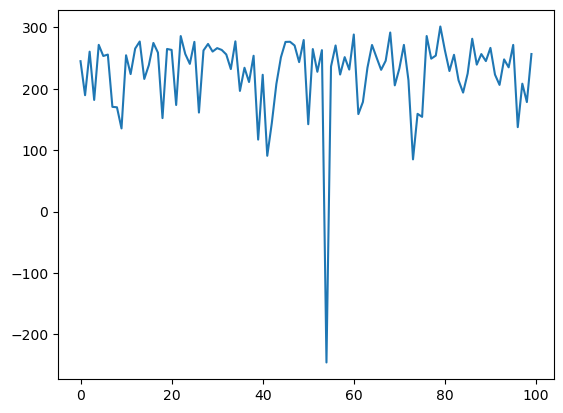

In [47]:
env = gym.make('LunarLander-v3')
env = gym.wrappers.RecordEpisodeStatistics(env)

gains = agent.play(env,100)

print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

plt.plot(np.array(env.return_queue))

Запуск симуляции с обученным агентом.

In [49]:
# создание экземпляра среды
env = gym.make('LunarLander-v3', render_mode='human')
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env,1)
print("Число шагов:", env.return_queue[-1])

env.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.10s/it]

Число шагов: 253.18607451632397


### Пример 3.

Рассмотрим задачу о машинке и холме MountainCar. Структуру ИНС используем ту же самую.

In [81]:
env = gym.make('MountainCar-v0', max_episode_steps=500)
env = gym.wrappers.RecordEpisodeStatistics(env, 2000)

print('Размерность вектора состояний: ', env.observation_space.shape[0])
print('Количество действий: ', env.action_space.n)

Размерность вектора состояний:  2
Количество действий:  3


In [83]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        #self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        return self.fc2(x)
    
model = QNetwork(env.observation_space.shape[0], env.action_space.n).to(device)
model_target = QNetwork(env.observation_space.shape[0], env.action_space.n).to(device)

# Гиперпараметры
BUFFER_SIZE = int(1e5)  # размер буфера памяти
BATCH_SIZE = 64         # размер пакета
UPDATE_EVERY = 4        # как часто проводить обучение сети
UPDATE_EVERY_Q = 50     # как часто обновлять параметры целевой сети

In [85]:
agent = DQNAgent(env, model, model_target)

s, _ = env.reset()
print(s)

agent.get_action(s)

[-0.47317782  0.        ]


1

In [57]:
agent.epsilon

0.1

In [129]:
gains = DQN_control(env, agent, num_episodes=1500, eps_start=1.0, eps_decay = 0.999, eps_min= 0.01, goal_score = -150);

Доход: -500.00 в эпизоде 0
--- 0.19337701797485352 сек ---
Доход: -500.00 в эпизоде 50
--- 10.866490840911865 сек ---
Доход: -500.00 в эпизоде 100
--- 11.06941032409668 сек ---
Доход: -500.00 в эпизоде 150
--- 11.242945671081543 сек ---
Доход: -500.00 в эпизоде 200
--- 11.296802043914795 сек ---
Доход: -500.00 в эпизоде 250
--- 11.49128270149231 сек ---
Доход: -500.00 в эпизоде 300
--- 11.6578369140625 сек ---
Доход: -500.00 в эпизоде 350
--- 11.830376148223877 сек ---
Доход: -500.00 в эпизоде 400
--- 11.757570505142212 сек ---
Доход: -493.10 в эпизоде 450
--- 11.436429023742676 сек ---
Доход: -493.10 в эпизоде 500
--- 12.498589992523193 сек ---
Доход: -491.06 в эпизоде 550
--- 11.585031270980835 сек ---
Доход: -444.58 в эпизоде 600
--- 9.819751262664795 сек ---
Доход: -356.34 в эпизоде 650
--- 7.421161890029907 сек ---
Доход: -286.43 в эпизоде 700
--- 6.484665632247925 сек ---
Доход: -253.83 в эпизоде 750
--- 5.880281209945679 сек ---
Доход: -231.52 в эпизоде 800
--- 5.461400985717773

In [97]:
agent.save_model("MountainCar_DDQN_128neurons")

Net saved to:  savedModels/MountainCar_DDQN_128neurons.pkl


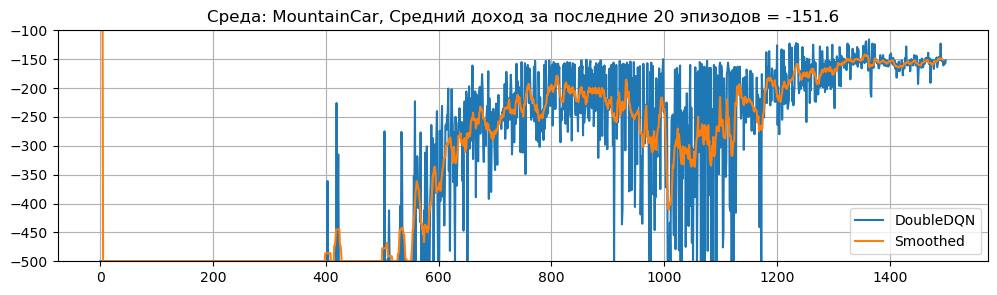

In [131]:
def plot_rewards(env_name, returns, label):
    # сглаженный вектор доходов
    returns_smoothed = np.pad(np.convolve(returns, np.ones(10)/10, mode='valid'),[5, 0])
    fig = plt.figure(figsize=(12, 3))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.plot(returns_smoothed, label="Smoothed")
    plt.grid()
    plt.legend()
    plt.ylim(-500, -100)
    plt.show()

returns = np.array(env.return_queue)
plot_rewards("MountainCar", returns, 'DoubleDQN')


In [63]:
agent.load_model("savedModels/MountainCar_DDQN_128neurons.pkl")

Model loaded


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 61.56it/s]

Средний доход:  -131.52
Минимальный доход:  -200.0


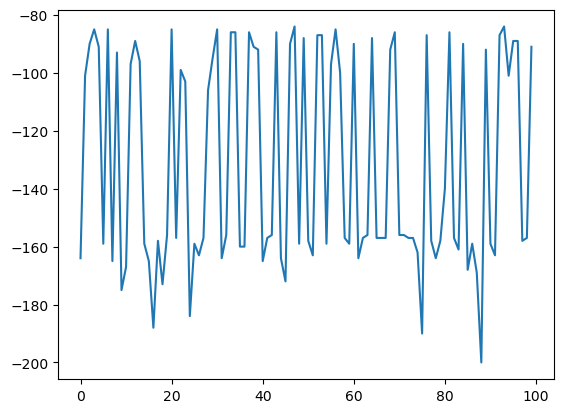

In [65]:
env = gym.make('MountainCar-v0')
env = gym.wrappers.RecordEpisodeStatistics(env)

gains = agent.play(env,100)

print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

plt.plot(np.array(env.return_queue))

In [89]:
# создание экземпляра среды
env = gym.make('MountainCar-v0', render_mode='human')
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env,1)
print("Число шагов:", env.return_queue[-1])

env.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.79s/it]

Число шагов: -200.0


### Задача

Модифицировать способ формирования вознаграждения так, чтобы с помощью метода DQN можно было бы получить успешные эпизоды среди первых 250 эпизодов обучения.

In [133]:
def DQN_control2(env, agent, num_episodes=10000, 
                      eps_start=1.0, eps_decay = 0.995, eps_min = 0.01,
                       goal_score=200):
    # Инициализация   
    agent.epsilon = eps_start
    start_time = time.time()  # счётчик времени выполнения
    running_gain = goal_score - 1
    
    for i in range(num_episodes):
        state, _ = env.reset()
        
        # запускаем эпизод взаимодействия со средой        
        while True:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)

####################################################
            # Изменить вознаграждения
            new_reward =  ???
            reward = new_reward
######################################################
            
            agent.update(state, action, reward, next_state, terminated)
            state = next_state
            if terminated or truncated:
                break
        
        # Снижение eps и alpha
        agent.epsilon = max(agent.epsilon * eps_decay, eps_min)
        
        if i % 50 ==0:
            running_gain = np.mean(np.array(env.return_queue)[-100:])
            print("\rДоход: {:.2f} в эпизоде {}".format(running_gain, i))
            print("--- {} сек ---".format(time.time() - start_time))
            start_time = time.time()

        # выход из цикла при достижении целевого среднего дохода
        if running_gain > goal_score:  
            print("Успех на эпизоде {}!".format(i))
            # поместить в целевую сеть итоговые веса
            agent.update_Qtarget(hard_update = True)
            break   

### Задача 

См. файл 2.4.2 RL_DoubleDQN_PyTorch_on.ipynb и лекции "Слайд 11". Реализовать для  модификацию метода DQN с приоритетным воспроизведением опыта. Сравнить обучение методом DQN с/без этой модификации.
